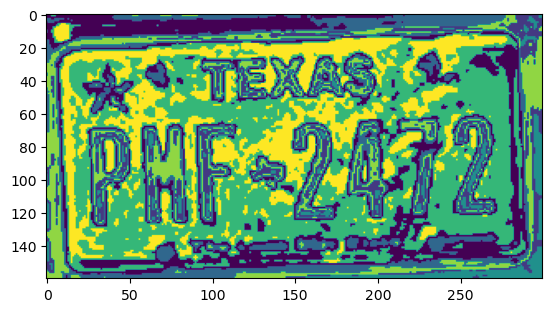

In [1]:
# Code to try and cluster a license plate into individual characters using kmeans
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

img = cv2.imread('PMF2472.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
Z = np.float32(img.reshape((-1,3)))

# Define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(Z, 7, None, criteria, 2, cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make the original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = np.uint8(label.reshape(img.shape[:2]))
res2.shape
plt.figure(1)
plt.imshow(res2)
plt.show()


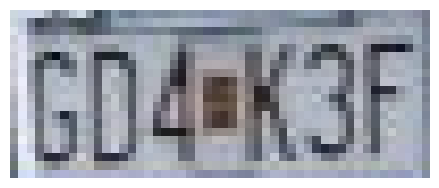

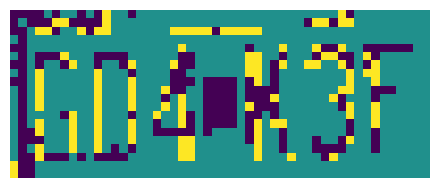

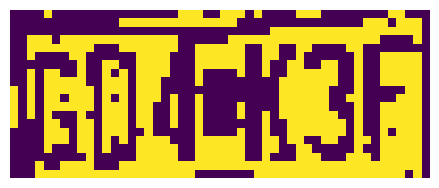

In [93]:
# Code to try and cluster license plate characters into individual characters
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Read and process image data
img= cv2.imread('20176940.jpg') 
img = img[10:30, 5:55]
cv2.imwrite('jkl.jpg',img)
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(img, [-1, 3])
rows, cols, chs = img.shape
# Run DBSCAN
db = DBSCAN(eps=20, min_samples=100, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_
# Change features
indices = np.dstack(np.indices(img.shape[:2]))
xycolors = np.concatenate((img, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_
# Plot
plt.figure(2)
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')

plt.figure(3)
plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels, [rows, cols]))
plt.axis('off')

plt.figure(4)
plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')
plt.show()

In [1]:
# Code to split characters up using CV contouring techniques.
# USed this code for ablation study. Final method to split characters
import cv2
import numpy as np
from imutils import contours
from PIL import Image
import matplotlib.pyplot as plt
# import required module
import os
 
# Function splits characters
def split_characters(filename, filename_only, fpath):
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(fpath)
    if not isExist:

        # Create a new directory because it does not exist
        os.makedirs(fpath)
        print("The new directory is created!")
    # Create folder for split characters to go in
    file_label = os.path.splitext(filename_only)[0]
    current_character_path = split_characters_directory + '\\split_' + file_label
    isExist_characters = os.path.exists(current_character_path)
    if not isExist_characters:

        # Create a new directory because it does not exist
        os.makedirs(current_character_path)
    # Change dir to that folder
    os.chdir(current_character_path)
    print(filename)
    image = cv2.imread(filename)
    #CV Binarize
    mask = np.zeros(image.shape, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Erode and dilate before processing contours
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(thresh, None, iterations=2)
    img_dilation = cv2.dilate(img_erosion, None, iterations=2)
    # Find contours
    cnts = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    ROI_number = 0
    # Sort contours by weighted area and save them in new file.
    for c in cnts:
        area = cv2.contourArea(c)
        if (area < 3200 and area > 350):
            x,y,w,h = cv2.boundingRect(c)
            ROI = 255 - thresh[y:y+h, x:x+w]
            cv2.drawContours(mask, [c], -1, (255,0,255), -1)
            cv2.imshow("Cont",mask)
            cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
            ROI_number += 1

    cv2.imshow('mask', thresh)
    cv2.imshow('thresh', img_dilation)
    cv2.waitKey()
    cv2.destroyAllWindows()
    resize_images(current_character_path,current_character_path)
# Resize images before saving for ML models to easily process data
def resize_images(folder_path,save_path):
    newsize = (75, 100)

    files = []
    for filename in os.listdir(folder_path):
        files.append(filename.split('.')[0])
    # print(files)
    os.chdir(folder_path)
    for file in files:

        # file_path = os.path.join(label_path,filename)
        img_name = file+".png"
        img = cv2.imread(os.path.join(folder_path,img_name),0)
        _, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        #img = 255 - img
        [h,w] = img.shape
        if h < w:
            os.remove(os.path.join(folder_path,img_name))
            continue
        else:
            height = h+10
            l_border = np.floor((height - w)/2) 
            r_border = height-l_border-w
            img = cv2.copyMakeBorder(img, 5, 5, int(l_border), int(r_border), cv2.BORDER_CONSTANT, value = 255)
            img = cv2.resize(img,newsize)
            cv2.imwrite(os.path.join(save_path,img_name),img)
# assign directory
boundingbox_directory = r"C:\Users\aksha\OneDrive\Desktop\Desktop\Fall 2022\Introduction to ML and AI\Project\Good boxes"
split_characters_directory = r"C:\Users\aksha\OneDrive\Desktop\Desktop\Fall 2022\Introduction to ML and AI\Project\Split_Characters"
# iterate over files in that directory
for filename in os.listdir(boundingbox_directory):

    file_path = os.path.join(boundingbox_directory,filename)
    filename_only = os.path.basename(filename)
    split_characters(file_path, filename_only, split_characters_directory)


os.chdir(boundingbox_directory)     

C:\Users\aksha\OneDrive\Desktop\Desktop\Fall 2022\Introduction to ML and AI\Project\Good boxes\01334X2.jpg


KeyboardInterrupt: 

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25847 sha256=bfa414ffa5eedcf7541cd0f3962b374c464cd57f37864c1944828af0d58201fa
  Stored in directory: c:\users\aksha\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils
